<a href="https://colab.research.google.com/github/kylehounslow/bmw-2019/blob/master/notebooks/object_measurement.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Object Detection and 3D measurement from point cloud  
___
Topics covered in this notebook:  
* Importing code from Github to work with Colab  
* Object detection with YOLOv3  
* Working with Depth images  
* Combining object detection and point cloud data to localize objects in 3D space.

## Make sure our runtime has a GPU attached usig `nvidia-smi` shell command

In [0]:
!nvidia-smi

Tue Jul 16 20:17:06 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.67       Driver Version: 410.79       CUDA Version: 10.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   51C    P8    16W /  70W |      0MiB / 15079MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

### Start by cloning the `bmw-2019` repository to our colab instance and installing the required libraries

---



In [0]:
!rm -rf gdg_workshop && git clone --quiet https://github.com/kylehounslow/gdg_workshop.git
!pip install --quiet -r gdg_workshop/requirements_colab.txt
!pip --quiet install youtube-dl
!apt-get -qq install ffmpeg

     |████████████████████████████████| 1.8MB 5.0MB/s 


### Import the YOLOV3 module and some other dependencies

In [0]:
from PIL import Image
import cv2
import numpy as np
import matplotlib.pyplot as plt
import youtube_dl
from google.colab.files import download
from gdg_workshop.models.keras_yolov3 import YOLOV3
from gdg_workshop import util
plt.style.use('default')
%matplotlib inline
%load_ext autoreload
%autoreload 2

Using TensorFlow backend.


### Instatiate the detector  
The `__init__` function for `YOLOV3` will take care of downloading the pretrained model weights and setting up the necessary variables for inference.  
See code [here](https://github.com/kylehounslow/bmw-2019/blob/master/models/keras_yolov3/src/yolo.py)

In [0]:
detector = YOLOV3()

weights file not found. Downloading...

W0716 20:18:05.681525 140045925455744 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0716 20:18:05.683376 140045925455744 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:181: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.

W0716 20:18:05.684720 140045925455744 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:186: The name tf.Session is deprecated. Please use tf.compat.v1.Session instead.



Done.
Done.


W0716 20:18:06.901447 140045925455744 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:190: The name tf.global_variables is deprecated. Please use tf.compat.v1.global_variables instead.

W0716 20:18:06.909496 140045925455744 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0716 20:18:09.348386 140045925455744 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:1834: The name tf.nn.fused_batch_norm is deprecated. Please use tf.compat.v1.nn.fused_batch_norm instead.

W0716 20:18:14.431665 140045925455744 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:2018: The name tf.image.resize_nearest_neighbor is deprecated. Please use tf.compat.v1.image.resize_nearest_neighbor in

/content/gdg_workshop/models/keras_yolov3/src/model_data/yolo.h5 model, anchors, and classes loaded.


W0716 20:18:20.102264 140045925455744 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/array_ops.py:1354: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


## Let's render the YOLOV3 Model Architecture in this notebook and explore

In [0]:
import numpy as np
import tensorflow as tf
from IPython.display import  HTML
def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = tf.compat.as_bytes("<stripped %d bytes>"%size)
    return strip_def
  
def rename_nodes(graph_def, rename_func):
    res_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = res_def.node.add() 
        n.MergeFrom(n0)
        n.name = rename_func(n.name)
        for i, s in enumerate(n.input):
            n.input[i] = rename_func(s) if s[0]!='^' else '^'+rename_func(s[1:])
    return res_def
  
def show_graph(graph_def, max_const_size=32):
    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph'+str(np.random.rand()))
  
    iframe = """
        <iframe seamless style="width:800px;height:620px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))
show_graph(tf.get_default_graph())

## Define a function to download image from URL and run detection
 The following defines a form widget for user input, downloads image and runs inference 

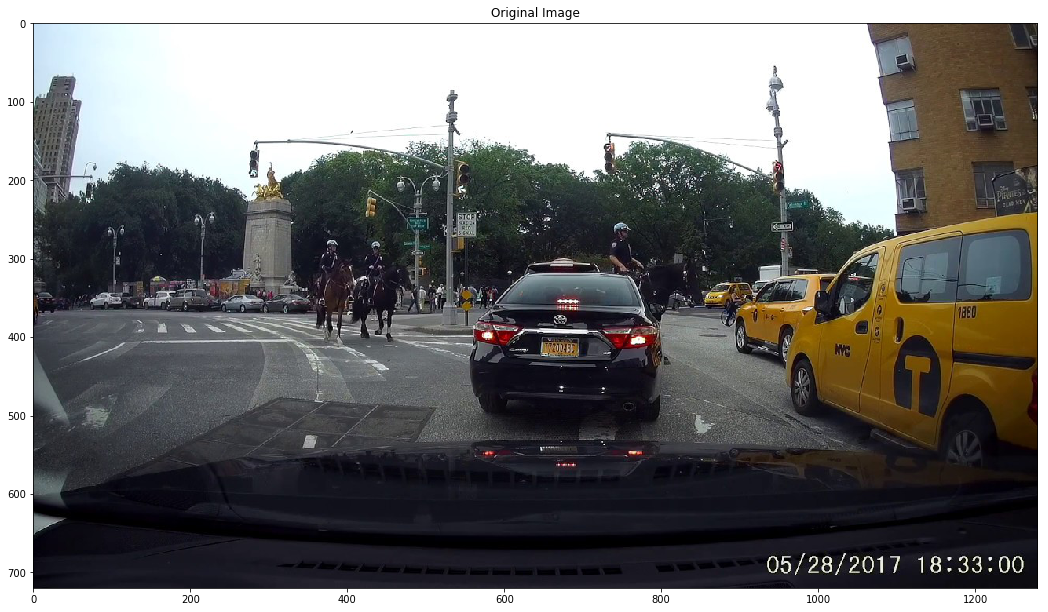

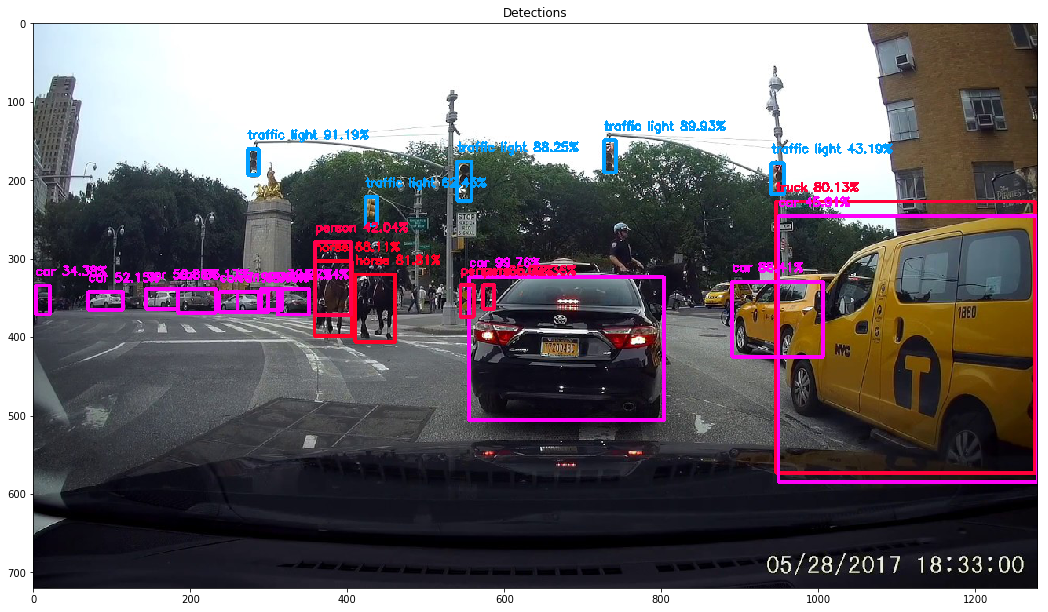

In [0]:
#@title ## Detect objects from image url
#@markdown ### Enter an image URL:
url = "https://i.ytimg.com/vi/gcI1BP1SlCk/maxresdefault.jpg" #@param {type:"string"}
img = util.download_image(url)
plt.figure(figsize=(18,12))
plt.title("Original Image")
plt.imshow(img)
plt.show()
detections = detector.detect(image=img)
img_draw = detector.draw_detections(img, detections)
plt.figure(figsize=(18,12))
plt.title("Detections")
plt.imshow(img_draw)

## Or we can capture image from client webcam

<IPython.core.display.Javascript object>

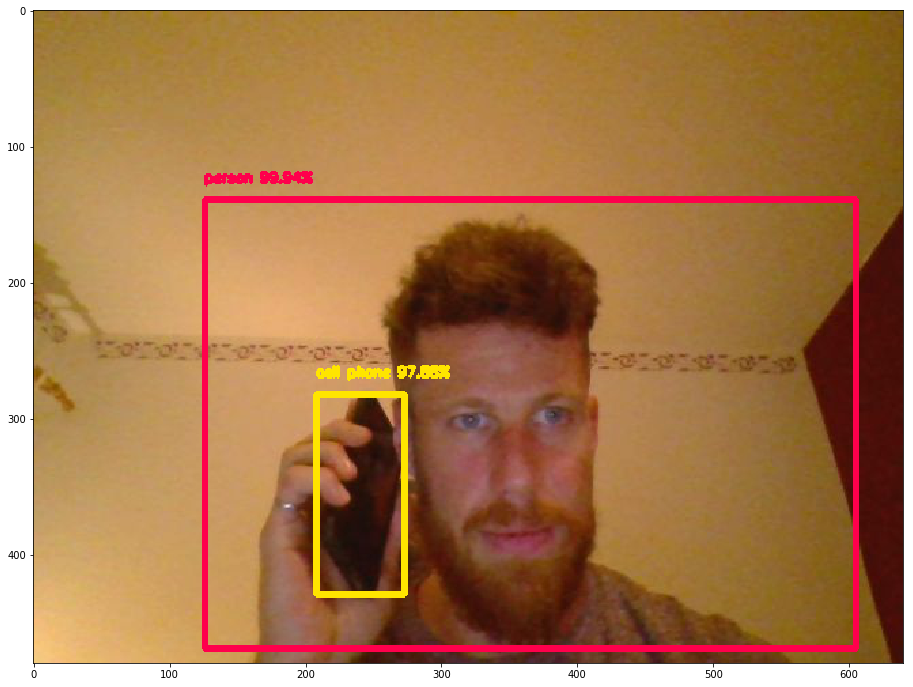

In [0]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode
from IPython.display import Image
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt


def take_photo(filename='photo.jpg', quality=0.8):
    js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture and Detect';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
    display(js)
    data = eval_js('takePhoto({})'.format(quality))
    binary = b64decode(data.split(',')[1])
    with open(filename, 'wb') as f:
        f.write(binary)
    return filename

try:
    filename = take_photo()
    img = Image.open(filename)
    img = np.array(img)
    detections = detector.detect(image=cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    img_draw = detector.draw_detections(img, detections)
    plt.figure(figsize=(18,12))
    plt.imshow(img_draw)
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
    print(str(err))

### Or we can upload an image and run detection 

In [0]:
from PIL import Image
import cv2
from google.colab import files
def upload_detect_show(detector):
    uploaded_files = files.upload()
    image_filenames = list(uploaded_files.keys())
    for image_filename in image_filenames:
        image = Image.open(image_filename)
        detections = detector.detect(image=image)
        img_draw = detector.draw_detections(image, detections)
        return Image.fromarray(img_draw)
upload_detect_show(detector=detector)